In [1]:
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import face_recognition
from skimage.feature import hog
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
X = []
y = []
for j in range(1,51):
    for i in range(0,15):
        img_unmasked = cv2.imread("unmaskedSet/"+str(j)+"/"+str(i)+".png")
        img_unmasked_grey = cv2.cvtColor(img_unmasked,cv2.COLOR_BGR2GRAY)
        x_unmasked_feature = hog(img_unmasked_grey, orientations=8, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), visualize=False, multichannel=False)# extract hog feature
        X.append(x_unmasked_feature)
        y.append(0)
        img_masked = cv2.imread("maskSet/"+str(j)+"/"+str(i)+".png")
        img_masked_grey = cv2.cvtColor(img_masked,cv2.COLOR_BGRA2GRAY)
        x_masked_feature = hog(img_masked_grey, orientations=8, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), visualize=False, multichannel=False)
        X.append(x_masked_feature)
        y.append(1)
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=None, stratify=y)

<Figure size 144x144 with 0 Axes>

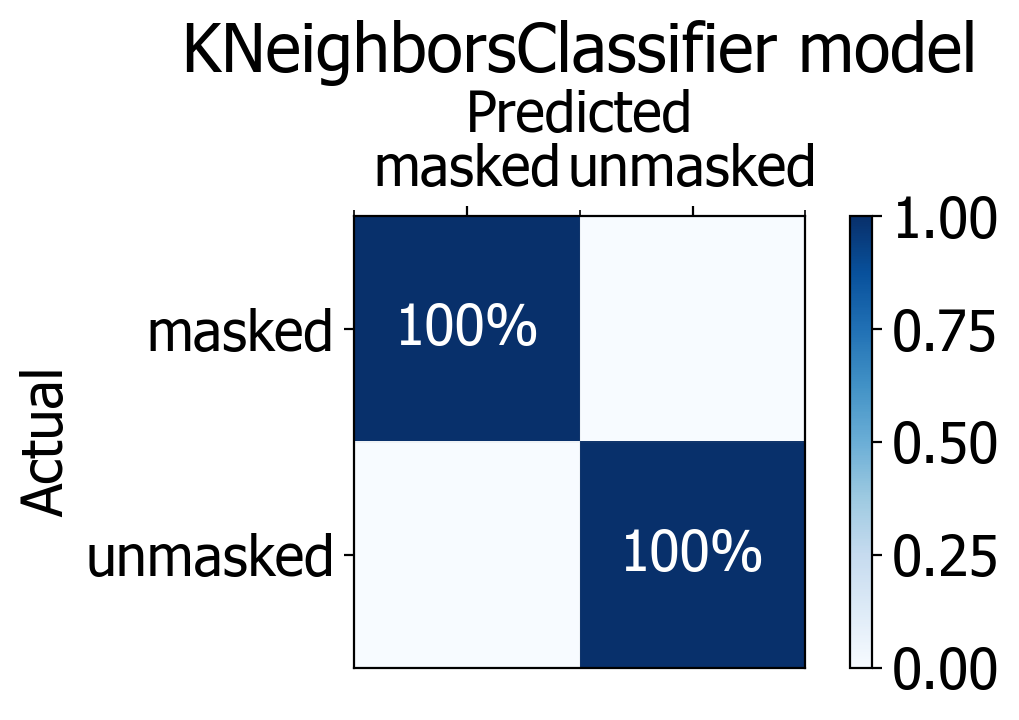

In [3]:
clf = KNeighborsClassifier()
clf.fit(x_train, y_train)
pre = clf.predict(x_test)
# draw confusion matrix
cm = confusion_matrix(y_pred=pre, y_true=y_test)
plt.rc('font',family='sans-serif',size='20')
plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'SimHei', 'Lucida Grande', 'Verdana']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(2, 2))
plt.rcParams['figure.dpi'] = 200
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if int(cm[i, j]*100 + 0.5) == 0:
            cm[i, j]=0
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sx = ['masked','unmasked']
sv = [0,1]
plt.title('Confusion matrix')
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=list(range(2)), yticklabels=list(range(2)),
           title='KNeighborsClassifier model',
           ylabel='Actual',
        xlabel='Predicted')
ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
ax.set_xticklabels(sx)
ax.set_yticklabels(sx)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.05)
ax.tick_params(which="minor", bottom=False, left=False)
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if int(cm[i, j]*100 + 0.5) > 0:
            ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                    ha="center", va="center",
                    color="white"  if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [4]:
x_known_images = []
nam = -1
known_threshold = 0.1 # the matched person pictures/total person pictures.
known_tolerance = 0.4 # the tolerance for compare_faces method.
y_known_label = []
for j in range(0,10): # only use the first 10 persons pictures
    for i in range(0,15):
        img = cv2.imread("maskSet/"+str(j+1)+"/"+str(i)+".png")
        x_known_images.append(face_recognition.face_encodings(img,[(0,150,150,0)])[0])
        y_known_label.append(j)
x_train, x_test, y_train, y_test = train_test_split(x_known_images, y_known_label,
                                                    test_size=0.2, random_state=None, stratify=y_known_label)
for j in range(11,15): # add 4 unknown persons pictures
    for i in range(0,15):
        img = cv2.imread("maskSet/"+str(j)+"/"+str(i)+".png")
        x_test.append(face_recognition.face_encodings(img, [(0,150,150,0)])[0])
        y_test.append(-1)
accept = 0 # correct recognition
wrongAccept = 0 # incorrect rejection(should be rejected but accepted)
wrongChoose = 0 # successful acceptance but wrong recognition
reject = 0 # correct rejection
wrongReject = 0 # incorrect acceptance(should be accepted but rejected)
for xe in range(0,len(x_test)):
    yp = [0]*10
    results = face_recognition.compare_faces(x_train,x_test[xe],tolerance=known_tolerance)
    for n in range(0,len(results)):
        if results[n]:
            yp[y_train[n]]+=1
    h = yp.index(max(yp))
    if max(yp)/(15*0.8)>known_threshold and h==y_test[xe]:
        accept+=1
    elif max(yp)/(15*0.8)>known_threshold and y_test[xe]!=-1 and h!=y_test[xe]:
        wrongChoose+=1
    elif max(yp)/(15*0.8)>known_threshold and y_test[xe]==-1:
        wrongAccept+=1
    elif max(yp)/(15*0.8)<=known_threshold and y_test[xe]!=-1:
        wrongReject+=1
    elif max(yp)/(15*0.8)<=known_threshold and y_test[xe]==-1:
        reject+=1
print("correct accept:",accept,"correct reject:",reject,
      "wrong accept:",wrongAccept,"wrong reject:",wrongReject,"wrong choose",wrongChoose,
      "frr:",wrongReject/(accept+wrongReject+wrongChoose),"far",wrongAccept/(reject+wrongAccept))

correct accept: 23 correct reject: 56 wrong accept: 4 wrong reject: 6 wrong choose 1 frr: 0.2 far 0.06666666666666667


In [5]:
from sklearn import neighbors
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=10, algorithm='auto',weights='distance') # use k neighbor to classify person
knn_clf.fit(x_train,y_train)
closest_distances = knn_clf.kneighbors(x_test,n_neighbors=10)
y_pred_after = []
for i in range(len(x_test)):
    yu = [0]*30
    for j in range(10):
        if closest_distances[0][i][j]<=known_tolerance: # use distance for recognizing tolerance (distance must be bigger than tolerance or the picture will be unmatched).
            yu[y_train[closest_distances[1][i][j]]]+=1
    if max(yu)/(15*0.8)>known_threshold: # the number of matched picture must be bigger than threshold for matching or it will be the unrecognized picture.
        y_pred_after.append(yu.index(max(yu)))
    else:
        y_pred_after.append(-1)
accept = 0
wrongAccept = 0
wrongChoose = 0
reject = 0
wrongReject = 0
for m in range(len(x_test)):
    if y_pred_after[m]==y_test[m] and y_test[m]==-1:
        reject+=1
    elif y_pred_after[m]==y_test[m] and y_test[m]!=-1:
        accept+=1
    elif y_pred_after[m]!=y_test[m] and y_test[m]!=-1 and y_pred_after[m]==-1:
        wrongReject+=1
    elif y_pred_after[m]!=y_test[m] and y_test[m]!=-1 and y_pred_after[m]!=-1:
        wrongChoose+=1
    else:
        wrongAccept+=1
print("correct accept:",accept,"correct reject:",reject,
      "wrong accept:",wrongAccept,"wrong reject:",wrongReject,"wrong choose",wrongChoose,
      "frr:",wrongReject/(accept+wrongReject+wrongChoose),"far",wrongAccept/(reject+wrongAccept))

correct accept: 23 correct reject: 56 wrong accept: 4 wrong reject: 6 wrong choose 1 frr: 0.2 far 0.06666666666666667


In [1]:
import torch
import cv2
import torch.nn as nn
from torch import optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__(),
        self.conv = nn.Sequential(
            nn.Conv2d(1, 20, 5, padding=2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, padding=1),
            nn.Conv2d(20, 25, 5, padding=2),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, padding=1),
        )
        self.convert = nn.Sequential(
                nn.Linear(36100, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
        )
    def forward(self, input):
        output = self.conv(input)
        output = output.view(output.shape[0], -1)
        output = self.convert(output)
        return output

def contrastive_loss(vec1, vec2, label):
    a = torch.sub(vec2, vec1)
    b = torch.pow(a, 2)
    c = torch.sqrt(torch.sum(b, dim=1))
    d = label * torch.pow(c, 2) + (1 - label) * torch.pow(torch.clamp(1 - c, min=0), 2)
    e = torch.mean(d) / 2
    return e
CNN = CNN()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)
x_train = []
y_train = []
x_test = []
y_test = []
for j in range(0,10):
    for i in range(0,15):
        img = cv2.imread("unmaskedSet/"+str(j+1)+"/"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
        if i < 12:
            x_train.append(img)
            y_train.append(j)
        else:
            x_test.append(img)
            y_test.append(j)

input1 = []
input2 = []
labels = []
for i in range(0,len(y_train)):
    for j in range(0, len(y_train)):
        if i < j:
            input1.append(x_train[i])
            input2.append(x_train[j])
            if y_train[i]==y_train[j]:
                labels.append(1)
            else:
                labels.append(0)

In [2]:
positive_input1 = []
positive_input2 = []
positive_labels = []
negative_input1 = []
negative_input2 = []
negative_labels = []
for i in range(len(labels)):
    if labels[i] == 1:
        positive_input1.append(input1[i])
        positive_input2.append(input2[i])
        positive_labels.append(1)
    else:
        negative_input1.append(input1[i])
        negative_input2.append(input2[i])
        negative_labels.append(0)
import random
negative_sample = random.sample(range(0,len(negative_labels)),len(positive_labels))
negative_sample_input1 = []
negative_sample_input2 = []
negative_sample_labels = [0]*len(positive_labels)
for i in range(0, len(positive_labels)):
    negative_sample_input1.append(negative_input1[negative_sample[i]])
    negative_sample_input2.append(negative_input2[negative_sample[i]])
data_input1 = []
data_input2 = []
data_labels = []
for i in range(0, len(positive_labels)):
    data_input1.append([positive_input1[i]])
    data_input2.append([positive_input2[i]])
    data_labels.append(positive_labels[i])
    data_input1.append([negative_sample_input1[i]])
    data_input2.append([negative_sample_input2[i]])
    data_labels.append(negative_sample_labels[i])

In [3]:
import torch.utils.data as Data
torch_dataset = Data.TensorDataset(torch.Tensor(data_input1), torch.Tensor(data_input2), torch.Tensor(data_labels))
loader = Data.DataLoader(dataset=torch_dataset, batch_size=30, shuffle=True)

In [ ]:
def compare_distance(vec1, vec2):
    a = torch.sub(vec2, vec1)
    b = torch.pow(a, 2)
    c = torch.sqrt(torch.sum(b, dim=1))
    return c

for iterate in range(0,100):
    for step, (im1, im2, lab) in enumerate(loader):
        optimizer.zero_grad()
        out1 = CNN(im1)
        out2 = CNN(im2)
        loss = contrastive_loss(out1, out2, lab)
        loss.backward()
        optimizer.step()

In [ ]:
for j in range(10,12):
    for i in range(0,15):
        img = cv2.imread("unmaskedSet/"+str(j+1)+"/"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
        x_test.append(img)
        y_test.append(-1)

In [ ]:
distanceThreshold = 0.6
y_pred_CNN = []
countt = 0
for data in x_test:
    test_vector = CNN(torch.Tensor([[data]]))
    distance = [0,0,0,0,0,0,0,0,0,0]
    for j in range(0,10):
        for i in range(0,12):
            img = cv2.imread("unmaskedSet/"+str(j+1)+"/"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
            obvec = CNN(torch.Tensor([[img]]))
            cal = compare_distance(obvec,test_vector)
            distance[j] += cal
    countt+=1
    tf = min(distance).tolist()[0]
    if tf/12 < distanceThreshold:
        y_pred_CNN.append(distance.index(min(distance)))
    else:
        y_pred_CNN.append(-1)

In [ ]:
accept = 0
wrongAccept = 0
wrongChoose = 0
reject = 0
wrongReject = 0
for m in range(len(x_test)):
    if y_pred_CNN[m]==y_test[m] and y_test[m]==-1:
        reject+=1
    elif y_pred_CNN[m]==y_test[m] and y_test[m]!=-1:
        accept+=1
    elif y_pred_CNN[m]!=y_test[m] and y_test[m]!=-1 and y_pred_CNN[m]==-1:
        wrongReject+=1
    elif y_pred_CNN[m]!=y_test[m] and y_test[m]!=-1 and y_pred_CNN[m]!=-1:
        wrongChoose+=1
    else:
        wrongAccept+=1
print("correct accept:",accept,"correct reject:",reject,
      "wrong accept:",wrongAccept,"wrong reject:",wrongReject,"wrong choose",wrongChoose,
      "frr:",wrongReject/(accept+wrongReject+wrongChoose),"far",wrongAccept/(reject+wrongAccept))

In [1]:
import torch
import cv2
import torch.nn as nn
from torch import optim
import numpy as np
import torch.utils.data as Data
import random

class Generator(nn.Module):
    def __init__(self, classNumber):
        super(Generator, self).__init__()
        self.classNumber = classNumber
        self.embedding = nn.Embedding(classNumber+1,10)
        self.once = nn.Sequential(
            nn.Conv2d(1, 32,5,padding=2,padding_mode='replicate'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3,2,padding=1),
            nn.Conv2d(32, 16, 5,padding=2, padding_mode='replicate'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(3,2,padding=1)
        )
        self.addFeature = nn.Sequential(
            nn.Linear(23114,23104),
            nn.LayerNorm(23104),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.twice = nn.Sequential(
            nn.ConvTranspose2d(16,32,4,2,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,4,2,1),
            nn.Tanh()
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0,0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.zero_()

    def forward(self, input, labels):
        out = self.once(input)
        out = out.view(out.shape[0],-1)
        label = self.embedding(labels)
        out = torch.cat([out,label],dim=1)
        out = self.addFeature(out)
        out = out.view(out.shape[0],16,38,-1)
        out = self.twice(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, classNumber):
        super(Discriminator, self).__init__()
        self.classNumber = classNumber
        self.once = nn.Sequential(
            nn.Conv2d(1, 32,5,padding=2,padding_mode='replicate'),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, 5, stride=2, padding=2, padding_mode='replicate'),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 1, 5, stride=2, padding=2, padding_mode='replicate'),
        )
        self.classify = nn.Sequential(
            nn.Linear(1444, 500),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, classNumber+1),
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0,0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.zero_()

    def forward(self, input):
        out = self.once(input)
        out = out.view(out.shape[0], -1)
        out = self.classify(out)
        return out

discriminator = Discriminator(10)
generator = Generator(10)
x_train = []
y_train = []
x_test = []
y_test = []
for j in range(0,10):
    for i in range(0,15):
        img = cv2.imread("unmaskedSet/"+str(j+1)+"/"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
        if i < 12:
            x_train.append(img)
            y_train.append(j+1)
        else:
            x_test.append(img)
            y_test.append(j+1)

for j in range(20,22):
    for i in range(0,15):
        img = cv2.imread("unmaskedSet/"+str(j)+"/"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
        x_test.append(img)
        y_test.append(0)

data_inputs = []
data_labels = []
for i in range(len(y_train)):
    data_inputs.append([x_train[i]])
    data_labels.append(y_train[i])
datas = [[]]*15

torch_dataset = Data.TensorDataset(torch.Tensor(data_inputs),torch.Tensor(data_labels))
loader = Data.DataLoader(dataset=torch_dataset, batch_size=2, shuffle=True)
for k in range(0,120):
    while True:
        i = random.randint(0,14)
        j = random.randint(41, 50)
        if not j in datas:
            datas[i].append(j)
            break

x_false = []
y_false = []
y_fake_label = []
for index, data in enumerate(datas):
    for j in data:
        img = cv2.imread("unmaskedSet/"+str(j)+"/"+str(index)+".png", cv2.IMREAD_GRAYSCALE)
        x_false.append([img])
        y_false.append(0)
        y_fake_label.append(j-40)
torch_dataset2 = Data.TensorDataset(torch.Tensor(x_false), torch.Tensor(y_false), torch.Tensor(y_fake_label))
loader2 = Data.DataLoader(dataset=torch_dataset2, batch_size=2, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizerD = optim.RMSprop(discriminator.parameters(), lr=0.0007)
optimizerG = optim.Adam(generator.parameters(), lr=0.001)
for iterate in range(0,50):
    for steps, (real_data, false_data) in enumerate(zip(loader, loader2)):
        real_img = real_data[0]
        real_label = torch.LongTensor(real_data[1].numpy())
        false_img = false_data[0]
        false_label = torch.LongTensor(false_data[1].numpy())
        optimizerD.zero_grad()
        fake_label = torch.LongTensor(false_data[2].numpy())
        fake = generator(false_img,fake_label)
        outputDr = discriminator(real_img)
        outputDf = discriminator(fake.detach())
        errReal = criterion(outputDr, real_label)
        errFalse = criterion(outputDf, false_label)
        errD = (errFalse+errReal)/2
        errD.backward()
        optimizerD.step()
        optimizerG.zero_grad()
        outputG = discriminator(fake)
        errG = criterion(outputG,fake_label)
        errG.backward()
        optimizerG.step()
    print("loss D:",errD,"loss G:",errG)

In [3]:
y_pred_GAN = []
for data in x_test:
    test_prob = discriminator(torch.Tensor([[data]]))
    _,idx = torch.topk(test_prob,1,dim = 1)
    y_pred_GAN.append(idx.tolist()[0][0])
accept = 0
wrongAccept = 0
wrongChoose = 0
reject = 0
wrongReject = 0
for m in range(len(x_test)):
    if y_pred_GAN[m]==y_test[m] and y_test[m]==0:
        reject+=1
    elif y_pred_GAN[m]==y_test[m] and y_test[m]!=0:
        accept+=1
    elif y_pred_GAN[m]!=y_test[m] and y_test[m]!=0 and y_pred_GAN[m]==0:
        wrongReject+=1
    elif y_pred_GAN[m]!=y_test[m] and y_test[m]!=0 and y_pred_GAN[m]!=0:
        wrongChoose+=1
    else:
        wrongAccept+=1
print("correct accept:",accept,"correct reject:",reject,
      "wrong accept:",wrongAccept,"wrong reject:",wrongReject,"wrong choose",wrongChoose,
      "frr:",wrongReject/(accept+wrongReject+wrongChoose),"far",wrongAccept/(reject+wrongAccept))

correct accept: 4 correct reject: 26 wrong accept: 4 wrong reject: 19 wrong choose 7 frr: 0.6333333333333333 far 0.13333333333333333


In [16]:
ii2 = cv2.imread("unmaskedSet/1/5.png",cv2.IMREAD_GRAYSCALE)
ui2 = discriminator(torch.Tensor([[ii2]]))
_, ind = torch.topk(ui2,1,dim=1)
print(ind.tolist()[0][0])

1


In [6]:
ii1 = cv2.imread("unmaskedSet/43/1.png",cv2.IMREAD_GRAYSCALE)
ui = generator(torch.Tensor([[ii1]]),torch.LongTensor([3]))
cv2.imshow("ll",ui.detach().numpy()[0][0])
cv2.waitKey()

-1

-1